# FLE Inspect Eval Analysis

This notebook loads `.eval` files from S3 and generates plots for production score over steps.

## Setup

Make sure you have the required packages:
```bash
pip install inspect-ai boto3 matplotlib pandas seaborn
```

In [14]:
from dotenv import load_dotenv
!pip install inspect-ai boto3 matplotlib pandas seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [15]:
import os
import dotenv
import tempfile
from pathlib import Path
from typing import List, Dict, Any, Optional
from dataclasses import dataclass

import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from inspect_ai.log import read_eval_log, EvalLog
load_dotenv()
# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

## Configuration

In [16]:
# S3 Configuration
S3_BUCKET = "dipika-lie-detection-data"
S3_PREFIX = "fle/open_test/"

# Local cache directory for downloaded files
CACHE_DIR = Path(tempfile.gettempdir()) / "fle_eval_cache"
CACHE_DIR.mkdir(exist_ok=True)

print(f"Cache directory: {CACHE_DIR}")

Cache directory: /var/folders/s2/zkqkmnrn44x221ggyn6t85340000gn/T/fle_eval_cache


## S3 Helper Functions

In [17]:
@dataclass
class EvalFileInfo:
    """Information about an eval file in S3."""
    key: str
    size: int
    last_modified: datetime
    filename: str
    
    @property
    def local_path(self) -> Path:
        return CACHE_DIR / self.filename


def list_eval_files(bucket: str = S3_BUCKET, prefix: str = S3_PREFIX) -> List[EvalFileInfo]:
    """List all .eval files in the S3 bucket."""
    s3 = boto3.client('s3')
    
    eval_files = []
    paginator = s3.get_paginator('list_objects_v2')
    
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get('Contents', []):
            key = obj['Key']
            if key.endswith('.eval'):
                eval_files.append(EvalFileInfo(
                    key=key,
                    size=obj['Size'],
                    last_modified=obj['LastModified'],
                    filename=Path(key).name
                ))
    
    # Sort by last modified date
    eval_files.sort(key=lambda x: x.last_modified)
    return eval_files


def download_eval_file(file_info: EvalFileInfo, bucket: str = S3_BUCKET) -> Path:
    """Download an eval file from S3 if not already cached."""
    local_path = file_info.local_path
    
    if local_path.exists():
        print(f"  Using cached: {file_info.filename}")
        return local_path
    
    print(f"  Downloading: {file_info.filename} ({file_info.size / 1024:.1f} KB)")
    s3 = boto3.client('s3')
    s3.download_file(bucket, file_info.key, str(local_path))
    
    return local_path

## List Available Eval Files

In [18]:
# List all eval files
eval_files = list_eval_files()

print(f"Found {len(eval_files)} eval files:\n")
for i, ef in enumerate(eval_files):
    size_kb = ef.size / 1024
    print(f"{i+1:3d}. {ef.filename[:60]}... ({size_kb:.1f} KB)")

Found 16 eval files:

  1. 2025-12-14T12-53-15+00-00_open-play-production_H5856E9niMkZm... (1161.2 KB)
  2. 2025-12-14T13-41-08+00-00_open-play-production_9voBEyX7E4pMo... (1446.9 KB)
  3. 2025-12-14T14-15-57+00-00_open-play-production_52YURkKDL9Rz7... (1.9 KB)
  4. 2025-12-14T14-19-25+00-00_open-play-production_AyHKB4Q8XTFGo... (23.8 KB)
  5. 2025-12-14T14-20-26+00-00_open-play-production_3jp66twBbVq4C... (154.2 KB)
  6. 2025-12-14T14-29-31+00-00_open-play-production_Z95t3rQeRiajf... (6.3 KB)
  7. 2025-12-14T14-36-08+00-00_open-play-production_TqnqKTV7Tm4vs... (1.9 KB)
  8. 2025-12-14T14-42-07+00-00_open-play-production_N6hbdPXvgnUkG... (944.0 KB)
  9. 2025-12-14T15-00-52+00-00_open-play-production_mm7r9whYcqAc3... (1.8 KB)
 10. 2025-12-14T15-02-40+00-00_open-play-production_ZufjuRDZgJ6X2... (122.2 KB)
 11. 2025-12-14T15-15-34+00-00_open-play-production_2YsZAkKggsfr7... (3716.5 KB)
 12. 2025-12-14T16-00-39+00-00_open-play-production_PhcajQxs3yjts... (66.9 KB)
 13. 2025-12-14T16-01-24+

## Load and Extract Trajectory Data

In [19]:
@dataclass
class TrajectoryResult:
    """Extracted trajectory data from an eval log."""
    filename: str
    model: str
    task: str
    status: str
    steps: List[int]
    scores: List[float]
    timestamps: List[datetime]  # Timestamp for each step
    final_score: float
    total_steps: int
    timestamp: datetime  # Start timestamp
    sample_id: str = ""
    error: Optional[str] = None
    metadata: Dict[str, Any] = None


def extract_intermediate_scores_from_events(sample) -> List[Dict[str, Any]]:
    """Extract intermediate scores from transcript ScoreEvents.
    
    Returns a list of dicts with 'step', 'score', 'timestamp' for each intermediate score.
    """
    intermediate_scores = []
    
    # Try to access events (new API)
    events = None
    if hasattr(sample, 'events') and sample.events:
        events = sample.events
    elif hasattr(sample, 'transcript') and sample.transcript:
        if hasattr(sample.transcript, 'events'):
            events = sample.transcript.events
    
    if not events:
        return intermediate_scores
    
    for event in events:
        event_type = type(event).__name__
        
        # Look for ScoreEvent with intermediate=True
        if event_type == 'ScoreEvent' and getattr(event, 'intermediate', False):
            score_obj = event.score
            if score_obj:
                step_num = 0
                prod_score = 0.0
                ts = event.timestamp if hasattr(event, 'timestamp') else None
                
                # Get score value
                if hasattr(score_obj, 'value'):
                    prod_score = float(score_obj.value) if score_obj.value else 0.0
                
                # Get step number from metadata
                if hasattr(score_obj, 'metadata') and score_obj.metadata:
                    meta = score_obj.metadata
                    if 'total_steps' in meta:
                        step_num = int(meta['total_steps'])
                    # Use production_score if available (more reliable)
                    if 'production_score' in meta:
                        prod_score = float(meta['production_score'])
                
                intermediate_scores.append({
                    'step': step_num,
                    'score': prod_score,
                    'timestamp': ts
                })
    
    # Sort by step number
    intermediate_scores.sort(key=lambda x: x['step'])
    
    return intermediate_scores


def extract_trajectory_data(log: EvalLog, filename: str) -> List[TrajectoryResult]:
    """Extract production score trajectories from an EvalLog.
    
    Parses intermediate ScoreEvents from the transcript to get step-by-step scores.
    Returns a list of TrajectoryResult objects, one per sample with valid trajectory data.
    """
    results = []
    
    try:
        # Get basic info
        model = log.eval.model if log.eval else "unknown"
        task = log.eval.task if log.eval else "unknown"
        status = log.status
        
        # Parse timestamp from filename
        try:
            ts_str = filename.split('_')[0]
            timestamp = datetime.fromisoformat(ts_str.replace('T', ' ').replace('-', ':', 2).replace('-', ':')[:19])
        except:
            timestamp = datetime.now()
        
        # Extract data from each sample
        if log.samples:
            for sample in log.samples:
                sample_id = sample.id if sample.id else ""
                error = None
                metadata = {}
                
                # Extract intermediate scores from ScoreEvents
                intermediate_scores = extract_intermediate_scores_from_events(sample)
                
                if intermediate_scores:
                    # Build trajectory from intermediate scores
                    steps = [s['step'] for s in intermediate_scores]
                    scores = [s['score'] for s in intermediate_scores]
                    timestamps = [s['timestamp'] for s in intermediate_scores]
                    
                    final_score = scores[-1] if scores else 0.0
                    total_steps = steps[-1] if steps else 0
                    
                    # Also get error from store if present
                    if hasattr(sample, 'store') and sample.store:
                        store = sample.store
                        if isinstance(store, dict):
                            error_key = 'TrajectoryData:error'
                            if error_key in store and store[error_key]:
                                error = store[error_key]
                    
                    # Get additional metadata from final score
                    if sample.scores:
                        for score_name, score_obj in sample.scores.items():
                            if hasattr(score_obj, 'metadata') and score_obj.metadata:
                                meta = score_obj.metadata
                                if 'average_growth_per_step' in meta:
                                    metadata['avg_growth'] = meta['average_growth_per_step']
                                if 'total_growth' in meta:
                                    metadata['total_growth'] = meta['total_growth']
                                if 'max_single_step_gain' in meta:
                                    metadata['max_gain'] = meta['max_single_step_gain']
                    
                    results.append(TrajectoryResult(
                        filename=filename,
                        model=model,
                        task=task,
                        status=status,
                        steps=steps,
                        scores=scores,
                        timestamps=timestamps,
                        final_score=final_score,
                        total_steps=total_steps,
                        timestamp=timestamp,
                        sample_id=sample_id,
                        error=error,
                        metadata=metadata
                    ))
                else:
                    # Fallback: try to get from store (old method)
                    if hasattr(sample, 'store') and sample.store:
                        store = sample.store
                        if isinstance(store, dict):
                            scores_key = 'TrajectoryData:scores'
                            if scores_key in store and store[scores_key]:
                                scores = store[scores_key]
                                steps = list(range(1, len(scores) + 1))
                                final_score = store.get('TrajectoryData:final_score', 0.0) or 0.0
                                total_steps = store.get('TrajectoryData:total_steps', 0) or 0
                                error_val = store.get('TrajectoryData:error')
                                error = error_val if error_val else None
                                
                                results.append(TrajectoryResult(
                                    filename=filename,
                                    model=model,
                                    task=task,
                                    status=status,
                                    steps=steps,
                                    scores=scores,
                                    timestamps=[],  # No timestamps available from store
                                    final_score=final_score,
                                    total_steps=total_steps,
                                    timestamp=timestamp,
                                    sample_id=sample_id,
                                    error=error,
                                    metadata=metadata
                                ))
        
    except Exception as e:
        print(f"  Error extracting trajectory: {e}")
        import traceback
        traceback.print_exc()
    
    return results


def load_eval_logs(eval_files: List[EvalFileInfo], max_files: Optional[int] = None) -> List[TrajectoryResult]:
    """Load eval logs and extract trajectory data."""
    trajectories = []
    
    files_to_load = eval_files[:max_files] if max_files else eval_files
    
    print(f"Loading {len(files_to_load)} eval files...\n")
    
    for i, ef in enumerate(files_to_load):
        print(f"[{i+1}/{len(files_to_load)}] {ef.filename[:50]}...")
        
        try:
            # Download file
            local_path = download_eval_file(ef)
            
            # Load eval log
            log = read_eval_log(str(local_path))
            
            # Extract trajectory data (now returns list)
            trajs = extract_trajectory_data(log, ef.filename)
            if trajs:
                trajectories.extend(trajs)
                for traj in trajs:
                    print(f"    -> Sample {traj.sample_id[:20] if traj.sample_id else 'N/A'}: "
                          f"Score: {traj.final_score:.1f}, Steps: {len(traj.scores)}")
            else:
                print(f"    -> No valid trajectories found (status: {log.status})")
            
        except Exception as e:
            print(f"    -> Error loading: {e}")
    
    print(f"\nLoaded {len(trajectories)} trajectories successfully.")
    return trajectories

In [20]:
# Load all eval files (or set max_files to limit)
trajectories = load_eval_logs(eval_files, max_files=None)

Loading 16 eval files...

[1/16] 2025-12-14T12-53-15+00-00_open-play-production_H58...
  Using cached: 2025-12-14T12-53-15+00-00_open-play-production_H5856E9niMkZmuUnYoRayD.eval
    -> Sample open_play_production: Score: 6262.0, Steps: 7
    -> Sample open_play_production: Score: 12086.0, Steps: 10
    -> Sample open_play_production: Score: 7149.0, Steps: 8
    -> Sample open_play_production: Score: 17079.0, Steps: 7
    -> Sample open_play_production: Score: 9648.0, Steps: 7
    -> Sample open_play_production: Score: 26799.0, Steps: 10
    -> Sample open_play_production: Score: 23677.0, Steps: 10
    -> Sample open_play_production: Score: 41750.0, Steps: 10
[2/16] 2025-12-14T13-41-08+00-00_open-play-production_9vo...
  Using cached: 2025-12-14T13-41-08+00-00_open-play-production_9voBEyX7E4pMo9EdywG2Gb.eval
    -> Sample open_play_production: Score: 3345.0, Steps: 6
    -> Sample open_play_production: Score: 4483.0, Steps: 10
    -> Sample open_play_production: Score: 26284.0, Steps: 1

## Create Summary DataFrame

In [21]:
# Create summary dataframe
summary_data = []
for traj in trajectories:
    # Calculate duration if timestamps available
    duration_min = None
    if traj.timestamps and len(traj.timestamps) > 1 and traj.timestamps[0] and traj.timestamps[-1]:
        duration_min = (traj.timestamps[-1] - traj.timestamps[0]).total_seconds() / 60
    
    summary_data.append({
        'filename': traj.filename[:35],
        'sample_id': traj.sample_id[:15] if traj.sample_id else 'N/A',
        'model': traj.model.split('/')[-1][:25],  # Just model name, not provider
        'task': traj.task,
        'status': traj.status,
        'final_score': traj.final_score,
        'num_steps': len(traj.scores),
        'duration_min': round(duration_min, 1) if duration_min else None,
        'avg_growth': traj.metadata.get('avg_growth') if traj.metadata else None,
        'has_error': traj.error is not None
    })

df_summary = pd.DataFrame(summary_data)
print(f"Total trajectories: {len(df_summary)}")
print(f"Unique models: {df_summary['model'].nunique()}")
print(f"Unique files: {df_summary['filename'].nunique()}")
print(f"\\nScore Statistics:")
print(f"  Mean:   {df_summary['final_score'].mean():.1f}")
print(f"  Median: {df_summary['final_score'].median():.1f}")
print(f"  Max:    {df_summary['final_score'].max():.1f}")
print(f"  Min:    {df_summary['final_score'].min():.1f}")
df_summary

Total trajectories: 33
Unique models: 3
Unique files: 9
\nScore Statistics:
  Mean:   9260.1
  Median: 6915.0
  Max:    41750.0
  Min:    0.0


,filename,sample_id,model,task,status,final_score,num_steps,duration_min,avg_growth,has_error
0,2025-12-14T12-53-15+00-00_open-play,open_play_produ,claude-opus-4.5,open_play_production,success,6262.0,7,16.2,978.000000,False
1,2025-12-14T12-53-15+00-00_open-play,open_play_produ,claude-opus-4.5,open_play_production,success,12086.0,10,24.3,1238.777778,False
2,2025-12-14T12-53-15+00-00_open-play,open_play_produ,claude-opus-4.5,open_play_production,success,7149.0,8,19.7,969.428571,False
3,2025-12-14T12-53-15+00-00_open-play,open_play_produ,claude-opus-4.5,open_play_production,success,17079.0,7,14.9,2730.333333,False
4,2025-12-14T12-53-15+00-00_open-play,open_play_produ,claude-opus-4.5,open_play_production,success,9648.0,7,19.6,1443.833333,False
5,2025-12-14T12-53-15+00-00_open-play,open_play_produ,claude-opus-4.5,open_play_production,success,26799.0,10,27.6,2875.000000,False
6,2025-12-14T12-53-15+00-00_open-play,open_play_produ,claude-opus-4.5,open_play_production,success,23677.0,10,25.3,2521.555556,False
7,2025-12-14T12-53-15+00-00_open-play,open_play_produ,claude-opus-4.5,open_play_production,success,41750.0,10,27.9,4552.888889,False
8,2025-12-14T13-41-08+00-00_open-play,open_play_produ,claude-haiku-4.5,open_play_production,success,3345.0,6,8.3,669.000000,False
9,2025-12-14T13-41-08+00-00_open-play,open_play_produ,claude-haiku-4.5,open_play_production,success,4483.0,10,23.5,498.111111,False


## Plot: Production Score Over Steps

In [22]:
def plot_production_score_over_steps(
    trajectories: List[TrajectoryResult],
    title: str = "Production Score Over Steps",
    figsize: tuple = (14, 8),
    show_individual: bool = True,
    show_mean: bool = True,
    alpha: float = 0.3
):
    """Plot production score trajectories over steps."""
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Filter trajectories with actual score data
    valid_trajectories = [t for t in trajectories if len(t.scores) > 0]
    
    if not valid_trajectories:
        print("No trajectories with score data found!")
        return fig, ax
    
    # Color palette
    colors = sns.color_palette('husl', len(valid_trajectories))
    
    # Plot individual trajectories
    if show_individual:
        for i, traj in enumerate(valid_trajectories):
            label = f"{traj.model[:20]}... (final: {traj.final_score:.1f})"
            ax.plot(
                traj.steps, 
                traj.scores, 
                alpha=alpha,
                color=colors[i],
                linewidth=1.5,
                label=label if len(valid_trajectories) <= 10 else None
            )
    
    # Calculate and plot mean trajectory
    if show_mean and len(valid_trajectories) > 1:
        # Find max steps across all trajectories
        max_steps = max(len(t.scores) for t in valid_trajectories)
        
        # Interpolate all trajectories to same length
        import numpy as np
        interpolated = []
        for traj in valid_trajectories:
            if len(traj.scores) > 1:
                x_old = np.linspace(0, 1, len(traj.scores))
                x_new = np.linspace(0, 1, max_steps)
                y_interp = np.interp(x_new, x_old, traj.scores)
                interpolated.append(y_interp)
        
        if interpolated:
            interpolated = np.array(interpolated)
            mean_scores = np.mean(interpolated, axis=0)
            std_scores = np.std(interpolated, axis=0)
            steps = np.arange(1, max_steps + 1)
            
            # Plot mean with confidence band
            ax.plot(steps, mean_scores, 'k-', linewidth=3, label='Mean', zorder=10)
            ax.fill_between(
                steps, 
                mean_scores - std_scores, 
                mean_scores + std_scores,
                alpha=0.2, 
                color='black',
                label='±1 std'
            )
    
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel('Production Score', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    if len(valid_trajectories) <= 10 or show_mean:
        ax.legend(loc='upper left', fontsize=9)
    
    ax.grid(True, alpha=0.3)
    
    # Add summary stats
    final_scores = [t.final_score for t in valid_trajectories]
    stats_text = f"n={len(valid_trajectories)}\nMean final: {np.mean(final_scores):.1f}\nMax: {np.max(final_scores):.1f}"
    ax.text(
        0.98, 0.02, stats_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    
    plt.tight_layout()
    return fig, ax

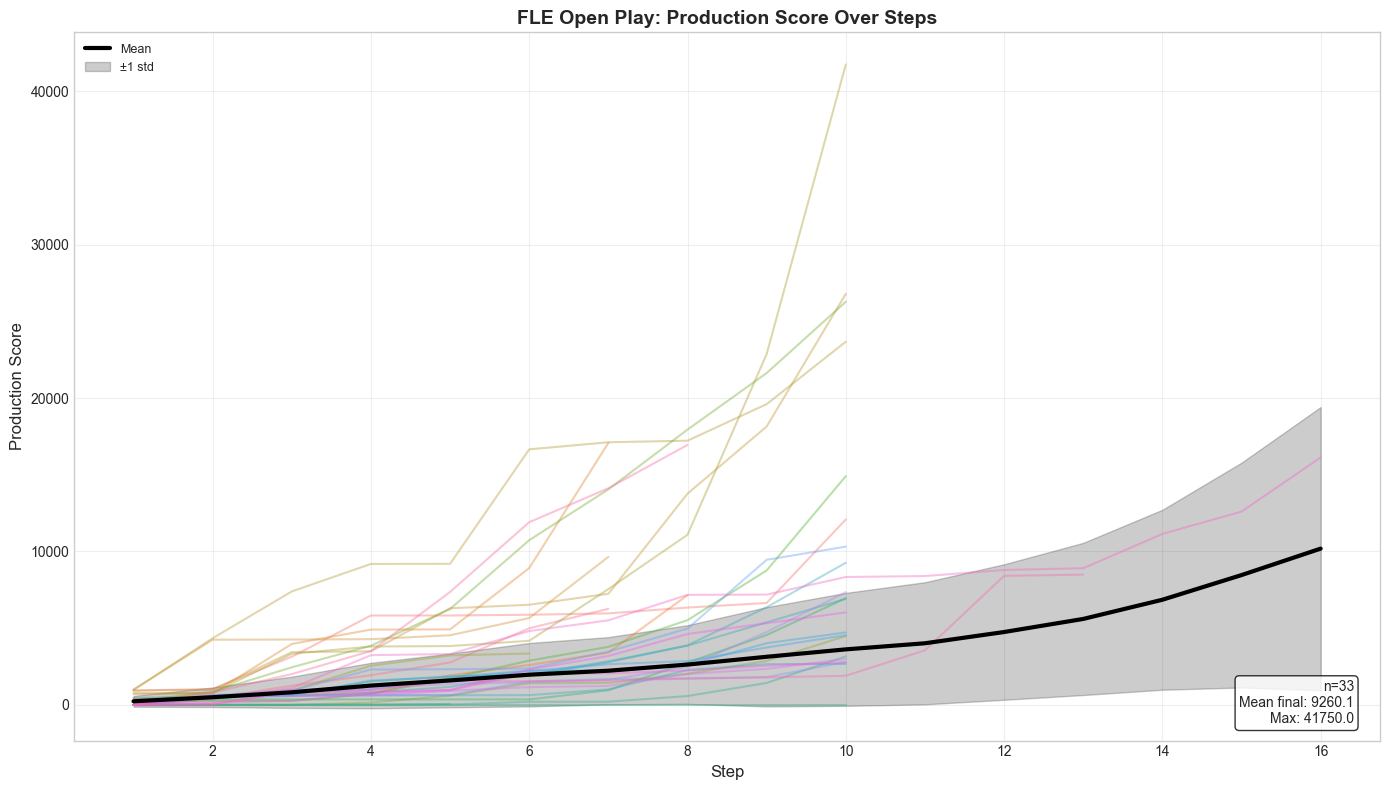

In [23]:
# Plot all trajectories
fig, ax = plot_production_score_over_steps(
    trajectories,
    title="FLE Open Play: Production Score Over Steps",
    show_individual=True,
    show_mean=True,
    alpha=0.4
)
plt.show()

## Plot: Final Scores Distribution

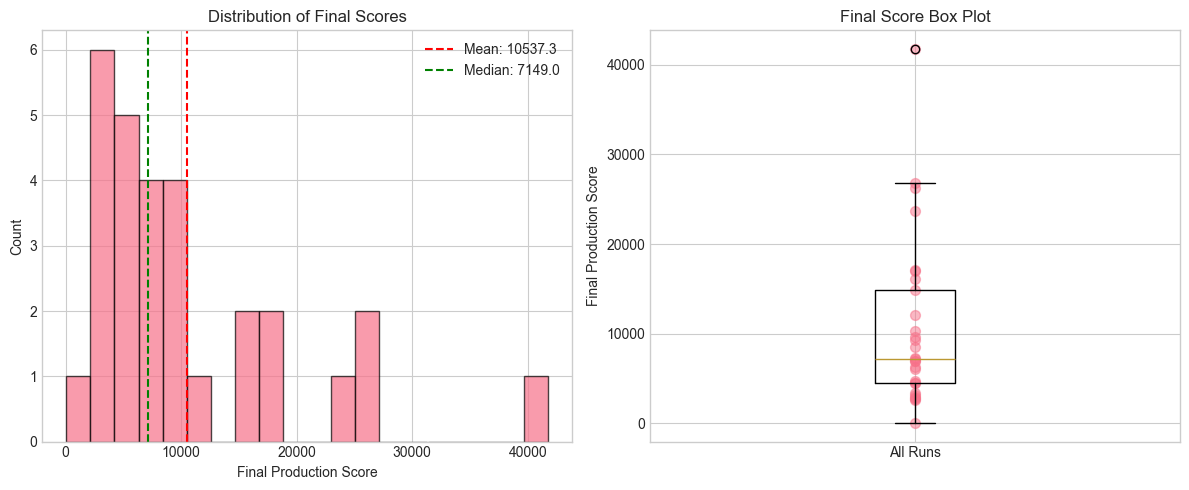


Final Score Statistics:
  Count: 29
  Mean:  10537.34
  Std:   9191.85
  Min:   60.00
  Max:   41750.00
  Median: 7149.00


In [24]:
def plot_final_scores_distribution(trajectories: List[TrajectoryResult], figsize: tuple = (12, 5)):
    """Plot distribution of final scores."""
    
    valid_trajectories = [t for t in trajectories if t.final_score > 0]
    
    if not valid_trajectories:
        print("No valid trajectories found!")
        return
    
    final_scores = [t.final_score for t in valid_trajectories]
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Histogram
    axes[0].hist(final_scores, bins=20, edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(final_scores), color='red', linestyle='--', label=f'Mean: {np.mean(final_scores):.1f}')
    axes[0].axvline(np.median(final_scores), color='green', linestyle='--', label=f'Median: {np.median(final_scores):.1f}')
    axes[0].set_xlabel('Final Production Score')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribution of Final Scores')
    axes[0].legend()
    
    # Box plot
    axes[1].boxplot(final_scores, vert=True)
    axes[1].scatter([1] * len(final_scores), final_scores, alpha=0.5, s=50)
    axes[1].set_ylabel('Final Production Score')
    axes[1].set_title('Final Score Box Plot')
    axes[1].set_xticklabels(['All Runs'])
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nFinal Score Statistics:")
    print(f"  Count: {len(final_scores)}")
    print(f"  Mean:  {np.mean(final_scores):.2f}")
    print(f"  Std:   {np.std(final_scores):.2f}")
    print(f"  Min:   {np.min(final_scores):.2f}")
    print(f"  Max:   {np.max(final_scores):.2f}")
    print(f"  Median: {np.median(final_scores):.2f}")

import numpy as np
plot_final_scores_distribution(trajectories)

## Plot: Score Growth Rate

## Plot: Score vs Wall Clock Time

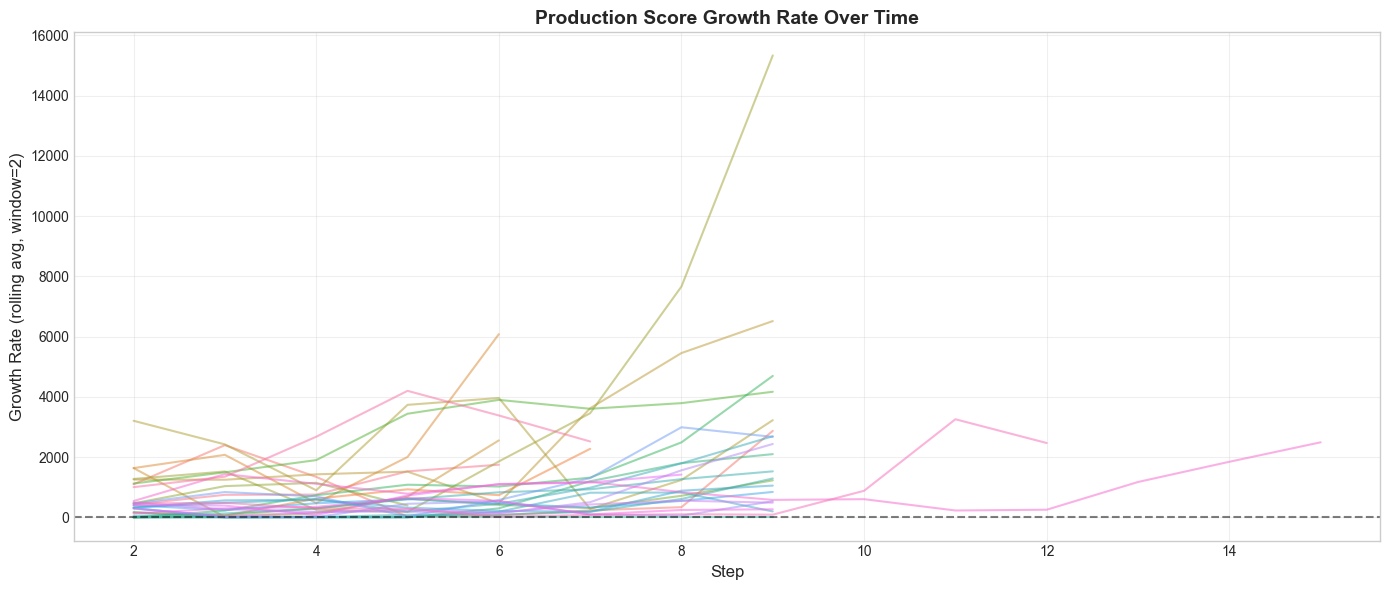

In [25]:
def plot_score_growth_rate(trajectories: List[TrajectoryResult], window: int = 3, figsize: tuple = (14, 6)):
    """Plot the growth rate of production scores (derivative)."""
    
    valid_trajectories = [t for t in trajectories if len(t.scores) > window]
    
    if not valid_trajectories:
        print("No trajectories with enough data found!")
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = sns.color_palette('husl', len(valid_trajectories))
    
    for i, traj in enumerate(valid_trajectories):
        scores = np.array(traj.scores)
        
        # Calculate rolling growth rate
        growth_rate = np.diff(scores)
        
        # Smooth with rolling average
        if len(growth_rate) >= window:
            smoothed = np.convolve(growth_rate, np.ones(window)/window, mode='valid')
            steps = np.arange(window, len(scores))
        else:
            smoothed = growth_rate
            steps = np.arange(1, len(growth_rate) + 1)
        
        ax.plot(steps, smoothed, alpha=0.5, color=colors[i], linewidth=1.5,
                label=f'{traj.model[:15]}...' if len(valid_trajectories) <= 10 else None)
    
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel(f'Growth Rate (rolling avg, window={window})', fontsize=12)
    ax.set_title('Production Score Growth Rate Over Time', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    if len(valid_trajectories) <= 10:
        ax.legend(loc='upper right', fontsize=9)
    
    plt.tight_layout()
    plt.show()

plot_score_growth_rate(trajectories, window=2)

In [ ]:
def plot_by_model(trajectories: List[TrajectoryResult], figsize: tuple = (14, 8)):
    """Plot mean production score over steps by model with 95% CI error bars."""
    
    from scipy import stats
    
    # Group by model
    model_groups = {}
    for traj in trajectories:
        if len(traj.scores) == 0:
            continue
        # Clean model name
        model = traj.model.split('/')[-1] if '/' in traj.model else traj.model
        if model not in model_groups:
            model_groups[model] = []
        model_groups[model].append(traj)
    
    if not model_groups:
        print("No valid trajectories found!")
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = sns.color_palette('husl', len(model_groups))
    
    for idx, (model, trajs) in enumerate(sorted(model_groups.items())):
        valid_trajs = [t for t in trajs if len(t.scores) > 0]
        
        if not valid_trajs:
            continue
        
        # Find max steps across trajectories for this model
        max_steps = max(len(t.scores) for t in valid_trajs)
        
        # Interpolate all trajectories to same length for proper averaging
        interpolated = []
        for traj in valid_trajs:
            if len(traj.scores) > 1:
                x_old = np.linspace(0, 1, len(traj.scores))
                x_new = np.linspace(0, 1, max_steps)
                y_interp = np.interp(x_new, x_old, traj.scores)
                interpolated.append(y_interp)
            elif len(traj.scores) == 1:
                # Single point - extend to all steps
                interpolated.append(np.full(max_steps, traj.scores[0]))
        
        if not interpolated:
            continue
        
        interpolated = np.array(interpolated)
        n_samples = len(interpolated)
        
        # Calculate mean and 95% CI
        mean_scores = np.mean(interpolated, axis=0)
        
        if n_samples > 1:
            # Standard error of the mean
            sem = stats.sem(interpolated, axis=0)
            # 95% CI using t-distribution
            ci_95 = sem * stats.t.ppf((1 + 0.95) / 2, n_samples - 1)
        else:
            ci_95 = np.zeros_like(mean_scores)
        
        steps = np.arange(1, max_steps + 1)
        
        # Plot mean line
        ax.plot(steps, mean_scores, '-', linewidth=2.5, color=colors[idx], 
                label=f'{model} (n={n_samples})')
        
        # Plot 95% CI band
        ax.fill_between(
            steps,
            mean_scores - ci_95,
            mean_scores + ci_95,
            alpha=0.2,
            color=colors[idx]
        )
    
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel('Production Score', fontsize=12)
    ax.set_title('Production Score Over Steps by Model (Mean ± 95% CI)', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add summary stats
    total_trajs = sum(len(trajs) for trajs in model_groups.values())
    stats_text = f"Total trajectories: {total_trajs}\nModels: {len(model_groups)}"
    ax.text(
        0.98, 0.02, stats_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\nModel Summary:")
    print("-" * 70)
    print(f"{'Model':<35} {'N':>5} {'Mean Score':>12} {'Std':>10} {'Max':>10}")
    print("-" * 70)
    for model, trajs in sorted(model_groups.items()):
        valid_trajs = [t for t in trajs if len(t.scores) > 0]
        if valid_trajs:
            final_scores = [t.final_score for t in valid_trajs]
            print(f"{model[:35]:<35} {len(valid_trajs):>5} {np.mean(final_scores):>12.1f} {np.std(final_scores):>10.1f} {np.max(final_scores):>10.1f}")

plot_by_model(trajectories)

## Plot: Comparison by Model

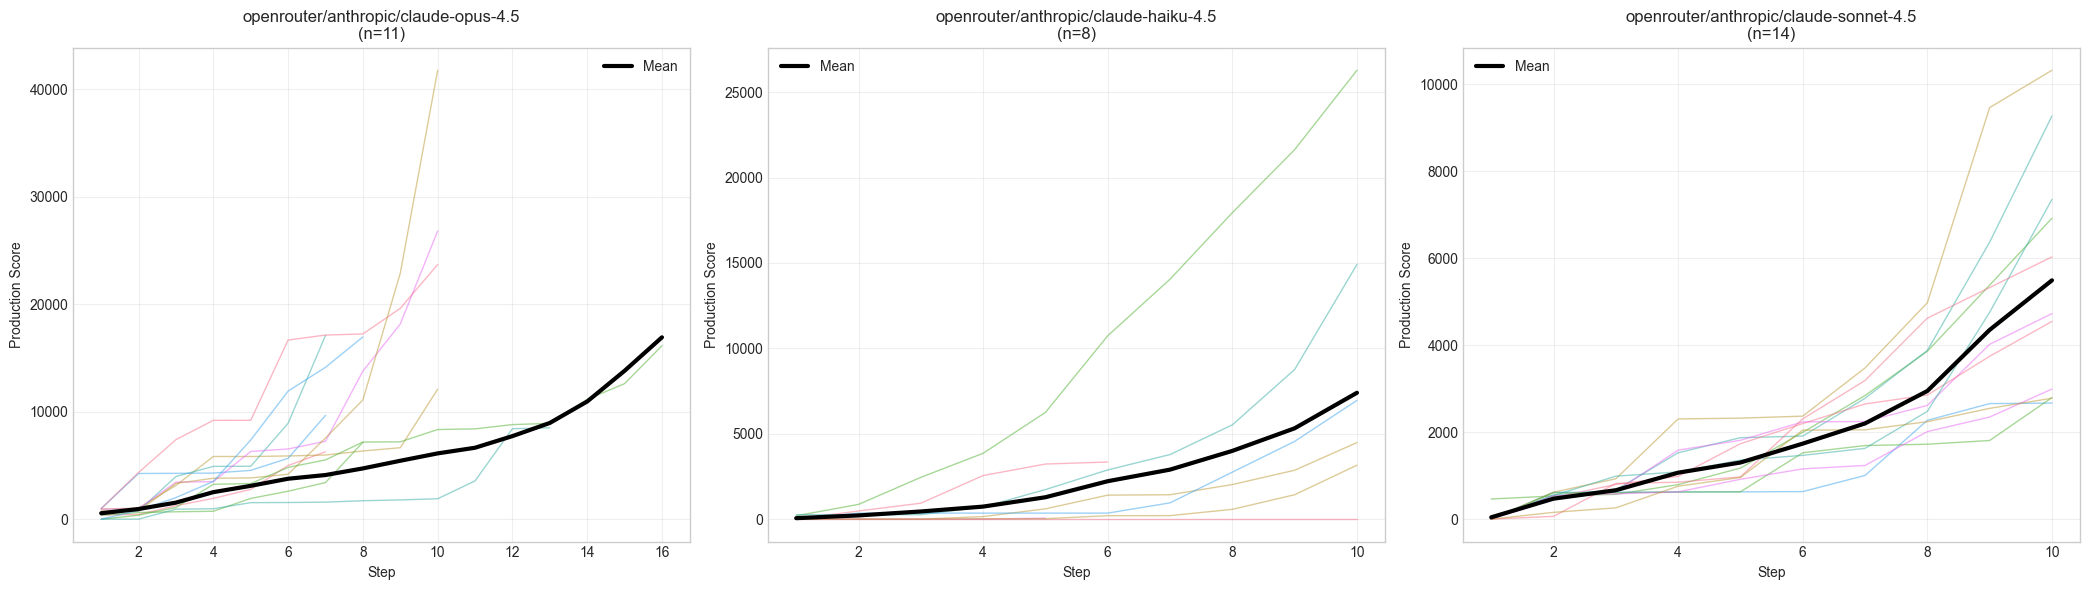

In [27]:
def plot_by_model(trajectories: List[TrajectoryResult], figsize: tuple = (14, 6)):
    """Plot trajectories grouped by model."""
    
    # Group by model
    model_groups = {}
    for traj in trajectories:
        model = traj.model
        if model not in model_groups:
            model_groups[model] = []
        model_groups[model].append(traj)
    
    if len(model_groups) <= 1:
        print("Only one model found, skipping model comparison plot.")
        return
    
    n_models = len(model_groups)
    fig, axes = plt.subplots(1, n_models, figsize=(7 * n_models, 6), squeeze=False)
    axes = axes.flatten()
    
    for idx, (model, trajs) in enumerate(model_groups.items()):
        ax = axes[idx]
        
        valid_trajs = [t for t in trajs if len(t.scores) > 0]
        
        for traj in valid_trajs:
            ax.plot(traj.steps, traj.scores, alpha=0.5, linewidth=1)
        
        # Calculate mean
        if valid_trajs:
            max_steps = max(len(t.scores) for t in valid_trajs)
            interpolated = []
            for traj in valid_trajs:
                if len(traj.scores) > 1:
                    x_old = np.linspace(0, 1, len(traj.scores))
                    x_new = np.linspace(0, 1, max_steps)
                    y_interp = np.interp(x_new, x_old, traj.scores)
                    interpolated.append(y_interp)
            
            if interpolated:
                mean_scores = np.mean(interpolated, axis=0)
                ax.plot(range(1, max_steps + 1), mean_scores, 'k-', linewidth=3, label='Mean')
        
        ax.set_xlabel('Step')
        ax.set_ylabel('Production Score')
        ax.set_title(f'{model}\n(n={len(valid_trajs)})')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_by_model(trajectories)

## Save Plots

In [28]:
# Save main plot to file
output_dir = Path("./eval_analysis_outputs")
output_dir.mkdir(exist_ok=True)

fig, ax = plot_production_score_over_steps(
    trajectories,
    title="FLE Open Play: Production Score Over Steps",
    show_individual=True,
    show_mean=True,
    alpha=0.4
)

output_path = output_dir / "production_score_over_steps.png"
fig.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Saved plot to: {output_path}")
plt.close()

Saved plot to: eval_analysis_outputs/production_score_over_steps.png


## Detailed Sample Inspection

In [29]:
def inspect_eval_log_details(file_info: EvalFileInfo):
    """Inspect an eval log file in detail."""
    local_path = download_eval_file(file_info)
    log = read_eval_log(str(local_path))
    
    print(f"=" * 60)
    print(f"File: {file_info.filename}")
    print(f"=" * 60)
    print(f"\nStatus: {log.status}")
    print(f"Version: {log.version}")
    
    if log.eval:
        print(f"\n--- Eval Spec ---")
        print(f"  Task: {log.eval.task}")
        print(f"  Model: {log.eval.model}")
        print(f"  Created: {log.eval.created}")
    
    if log.results:
        print(f"\n--- Results ---")
        print(f"  {log.results}")
    
    if log.samples:
        print(f"\n--- Samples ({len(log.samples)}) ---")
        for i, sample in enumerate(log.samples[:3]):  # Show first 3
            print(f"\n  Sample {i+1}:")
            print(f"    ID: {sample.id}")
            if sample.scores:
                print(f"    Scores: {list(sample.scores.keys())}")
                for name, score in sample.scores.items():
                    print(f"      {name}: value={score.value}")
                    if hasattr(score, 'metadata') and score.metadata:
                        print(f"        metadata keys: {list(score.metadata.keys())}")
            if hasattr(sample, 'store') and sample.store:
                print(f"    Store keys: {list(sample.store.keys()) if isinstance(sample.store, dict) else 'not dict'}")
    
    return log

# Inspect the largest file (likely has most data)
if eval_files:
    largest_file = max(eval_files, key=lambda x: x.size)
    log = inspect_eval_log_details(largest_file)

  Using cached: 2025-12-14T16-18-39+00-00_open-play-production_QZAzLNSaLH6fLpf274Swuo.eval
File: 2025-12-14T16-18-39+00-00_open-play-production_QZAzLNSaLH6fLpf274Swuo.eval

Status: success
Version: 2

--- Eval Spec ---
  Task: open_play_production
  Model: openrouter/anthropic/claude-opus-4.5
  Created: 2025-12-14T16:18:39+00:00

--- Results ---
  total_samples=4 completed_samples=4 scores=[EvalScore(name='unbounded_production_scorer', scorer='unbounded_production_scorer', reducer='mean', scored_samples=1, unscored_samples=0, params={}, metrics={'mean': EvalMetric(name='mean', value=10392.0, params={}, metadata=None)}, metadata=None)] metadata=None

--- Samples (4) ---

  Sample 1:
    ID: open_play_production_eval
    Scores: ['unbounded_production_scorer']
      unbounded_production_scorer: value=0.0
        metadata keys: ['production_score', 'total_steps', 'score_per_step', 'total_growth', 'average_growth_per_step', 'max_single_step_gain', 'first_production_step', 'scores_count', '